In [1]:
# STEP 1: Import Libraries
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from xgboost import XGBClassifier


In [2]:
# STEP 2: Setup Environment
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# STEP 3: Load and Combine the Dataset
def load_dataset():
    paths = {
        "Business": "news_dataset/business_data.csv",
        "Education": "news_dataset/education_data.csv",
        "Entertainment": "news_dataset/entertainment_data.csv",
        "Sports": "news_dataset/sports_data.csv",
        "Technology": "news_dataset/technology_data.csv"
    }
    all_data = []
    for category, path in paths.items():
        df = pd.read_csv(path)
        df["Category"] = category
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df = load_dataset()

In [ ]:
# STEP 4: Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'\W+|\d+', ' ', str(text).lower())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    return " ".join(tokens)

df['text'] = df['headlines'].fillna('') + ' ' + df['description'].fillna('') + ' ' + df['content'].fillna('')
df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
# STEP 5: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['Category']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Now use y_encoded instead of y in your train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Initialize models for tuning
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5, scoring='accuracy', verbose=1)
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', verbose=1)

# Direct models without tuning
nb_model = MultinomialNB()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Dictionary to manage all models
models = {
    "Logistic Regression (Tuned)": logreg_grid,
    "Multinomial Naive Bayes": nb_model,
    "Random Forest (Tuned)": rf_grid,
    "XGBoost": xgb_model
}

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    if "GridSearchCV" in str(type(model)):
        print(f"Best parameters for {name}: {model.best_params_}")
        best_model = model.best_estimator_
    else:
        best_model = model

    y_pred = best_model.predict(X_test)

    # Decode numeric predictions back to original category names
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_labels = label_encoder.inverse_transform(y_test)

    # Evaluation
    print(f"\nEvaluation for {name}")
    print(classification_report(y_test_labels, y_pred_labels))
    print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))


 Training Logistic Regression...
 Evaluation for Logistic Regression
               precision    recall  f1-score   support

     Business       0.97      0.96      0.97       400
    Education       1.00      0.99      0.99       400
Entertainment       0.99      0.99      0.99       400
       Sports       0.99      0.99      0.99       400
   Technology       0.95      0.97      0.96       400

     accuracy                           0.98      2000
    macro avg       0.98      0.98      0.98      2000
 weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[386   0   2   0  12]
 [  2 395   0   0   3]
 [  0   0 396   1   3]
 [  0   0   0 397   3]
 [  9   0   0   2 389]]

 Training Multinomial Naive Bayes...
 Evaluation for Multinomial Naive Bayes
               precision    recall  f1-score   support

     Business       0.97      0.96      0.97       400
    Education       1.00      0.99      0.99       400
Entertainment       0.99      0.99      0.99       40

c:\Users\srija\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:13:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Evaluation for XGBoost
               precision    recall  f1-score   support

     Business       0.98      0.96      0.97       400
    Education       0.99      0.99      0.99       400
Entertainment       0.99      0.98      0.99       400
       Sports       0.99      0.98      0.99       400
   Technology       0.94      0.96      0.95       400

     accuracy                           0.98      2000
    macro avg       0.98      0.98      0.98      2000
 weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[385   1   1   0  13]
 [  2 396   0   0   2]
 [  1   1 393   0   5]
 [  2   1   0 394   3]
 [  4   3   3   5 385]]


In [ ]:
# STEP 8: Save Best Model and Vectorizer
best_model = models["Logistic Regression"]
joblib.dump(best_model, "final_model.joblib")
joblib.dump(vectorizer, "vectorizer.joblib")
print("\n Model and vectorizer saved successfully!")


 Model and vectorizer saved successfully!


In [ ]:
# STEP 9: Save Predictions
df_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

# Decode actual and predicted labels back to original category names
df_test["Actual"] = label_encoder.inverse_transform(y_test)
df_test["Predicted"] = label_encoder.inverse_transform(best_model.predict(X_test))

df_test.to_csv("predictions.csv", index=False)
print(" Predictions saved to predictions.csv")


 Predictions saved to predictions.csv


Confusion Matrix Plot

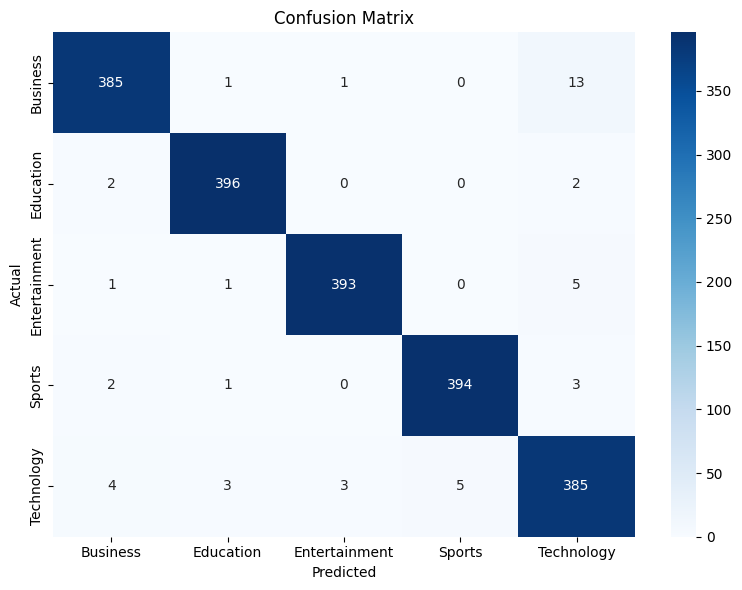

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Use label-encoded values for confusion matrix and decode labels for axis
encoded_labels = np.unique(y_test)
decoded_labels = label_encoder.inverse_transform(encoded_labels)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=encoded_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


Classification Report Metrics Plot

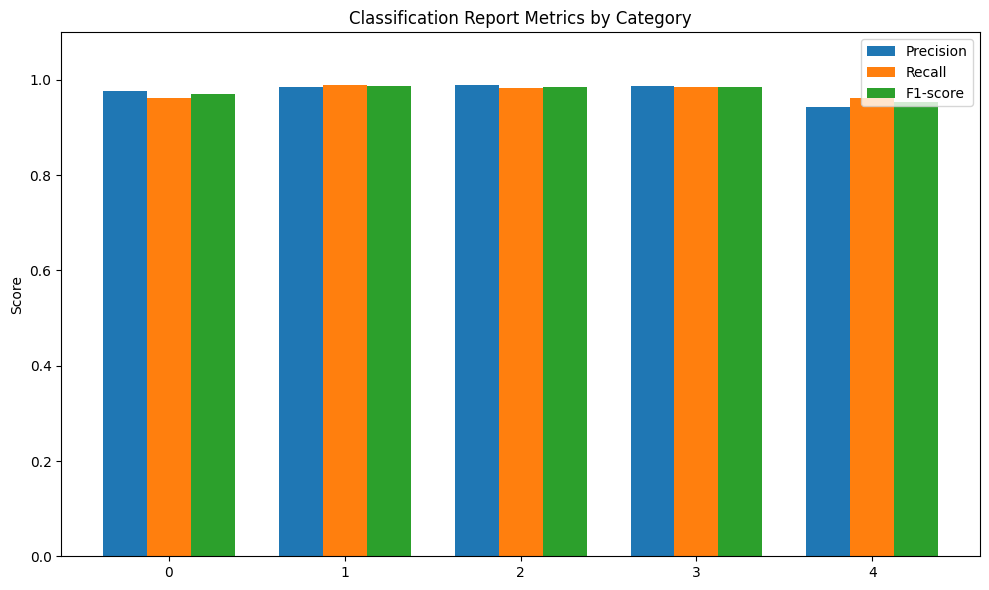

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Use the inverse transformed labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Extract sorted unique class names
labels = sorted(np.unique(y_test_labels))

# Generate the classification report with named labels
report = classification_report(y_test_labels, y_pred_labels, target_names=labels, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
data = {metric: [report[label][metric] for label in labels] for metric in metrics}

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, data[metric], width=width, label=metric.capitalize())

plt.xticks(x + width, labels, rotation=45)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Classification Report Metrics by Category")
plt.legend()
plt.tight_layout()
plt.savefig("classification_report_metrics.png")
plt.show()